# Introduction to Q# #


Q# (Q-sharp) is a domain-specific and [open source](https://github.com/microsoft/qsharp-compiler) programming language, part of [Microsoft's Quantum Development Kit (QDK)](https://docs.microsoft.com/en-us/quantum/), used for expressing quantum algorithms. It is to be used for writing subroutines that execute on an adjunct quantum processing unit (QPU), under the control of a classical host program and computer.




Operations and functions are the basic unit of execution in Q#. They are roughly equivalent to a function in C or C++ or Python, or a static method in C# or Java.

A Q# operation is a quantum subroutine. That is, it is a callable routine that contains quantum operations.

A Q# function is a classical subroutine used within a quantum algorithm. It may contain classical code but no quantum operations. Specifically, functions may not allocate or borrow qubits, nor may they call operations. It is possible, however, to pass them operations or qubits for processing. Functions are thus entirely deterministic in the sense that calling them with the same arguments will always produce the same result.

Together, operations and functions are called callables.




IQ#, the Q# Jupyter kernel, allows you to write Q# functions and operations directly on a code cell and compile them by running the cell (pressing Ctrl/⌘+Enter). For example:

In [1]:
function Hello(name: String) : Unit {

    // The following line will simply write a message to the console:
    Message($"Hello {name}!");

}

Hello

When you **Run** the cell, Q# compiles the code and returns the name of the callables it found. 
In this case, it finds only one callable (`Hello`) that accepts one argument (`name` of type `String`) 
and returns no value (`Unit`, roughly equivalent to `void` in C).

As you can see, Q# is structurally very similar to familiar
languages such as C# and Java in its use of semicolons to end
statements, curly brackets to group statements, function calls and doubleslash to introduce comments. 
It is a strongly typed language so all variables, arguments and return values
must have an associated type. Q# supports a familar set of classical types like:
- Int
- BigInt
- Bool
- Double

but also some quantum-specific:
- Qubit
- Result
- Pauli

The complete set of primitive types can be found in [Q# type model documentation](https://docs.microsoft.com/quantum/language/type-model#primitive-types).

In classical programs a bit, or binary digit, represents the basic unit of information and can be only one of two states: `0` or `1`.

Similarly, the **qubit**, or quantum bit, represents the basic unit of information for quantum algorithms. Like a bit, a qubit when measured can only be in one of two states:  $|0\rangle$ or  $|1\rangle$; however during execution, the state of the qubit represents *the probability of reading* $|0\rangle$ or $|1\rangle$. 

> For more information about qubits and their mathematical description, 
> take a look at [the qubit topic](https://docs.microsoft.com/quantum/concepts/the-qubit) inside 

In Q#, $|0\rangle$ and $|1\rangle$ are represented by `Result.Zero` and `Result.One` accordingly and qubits can only be allocated inside an operation with the `using` statement. When it gets allocated a qubit is always in the $|0\rangle$  state. To measure a qubit and read its value you use the [`M`](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.primitive.m) intrinsic operation.

As such, the next `HelloQuantum` operation always return `Result.Zero`:

In [2]:
operation HelloQuantum() : Result {
    using (q = Qubit()) {
        return M(q);
    }
}

HelloQuantum

To verify this, you can use the `%simulate` magic to simulate the execution of the operation in a QPU:

In [3]:
%simulate HelloQuantum

Zero

A more interesting example for a Q# operation is a quantum random number generator (QNRG). A QNRG returns a different value each time it is invoked:

In [4]:
open Microsoft.Quantum.Diagnostics;
    
operation QNRG() : Result {
    using (q = Qubit()) {
        H(q);
        let r = M(q);
        
        Reset(q);
        return r;
    }
}

QNRG

In [5]:
%simulate QNRG

One

As mentioned, one of the key characteristics of a qubit is that during execution it's state represents the probabiliy of measuring $|0\rangle$ or $|1\rangle$. In particular, the [`H`](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.intrinsic.h) intrinsic operation modifies the state of a qubit from $|0\rangle$ to a state in which there is 50% probability of measuring  $|0\rangle$ and 50% probability of measuring  $|1\rangle$.

> When the state of a qubit is such that it is not a 100% $|0\rangle$ or 100% $|1\rangle$, 
> we say the qubit is in **superposition** of $|0\rangle$ and $|1\rangle$.

The `QNRG` operation demonstrates some basic Q# features:

- Immutable variables are declared using `let`, in the previous example, the variable `r` is assigned the value returned by invoking `M` on qubit `q`.
- When de-allocated, qubits must be explicitly set back to $|0\rangle$, otherwise the simulator will report a runtime error. An easy way to achieve this is invoking [`Reset`](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.intrinsic.reset).



To verify the behavior of `QNRG`, we can create another Q# operation that invokes it 10 times and prints the result to the console:

In [6]:
operation Main() : Unit {
    for (i in 1..10) {
        Message($"{i}: {QNRG()}");
    }
}

Main

In [7]:
%simulate Main

1: Zero
2: One
3: Zero
4: Zero
5: Zero
6: Zero
7: Zero
8: One
9: One
10: One


()

Q# operations can return more than a single `Result`, let's modify `QRNG` to return an array:

In [8]:
open Microsoft.Quantum.Arrays;

operation QNRG2(n : Int) : Result[] {

    mutable r = new Result[n];
    
    using (qs = Qubit[n]) {
        ApplyToEach(H, qs);
        
        for (i in IndexRange(qs)) {
            // other languages: set r[i] <- M(qs[i]);
            set r w/= i <- M(qs[i]);
        }
        
        ResetAll(qs);
    }

    return r;
}

QNRG2

`QRNG2` demonstrates other Q# features:

- `mutable` is used to initialize variables that can be modified later in the code using `set`.
- `new Result[n]` is used to initialize a new `Result` array of size `n`.
- `[]` is used to access the element of an array.
- New arrays can be created from existing ones via [copy-and-update expressions](https://docs.microsoft.com/en-us/quantum/language/expressions?view=qsharp-preview#copy-and-update-expressions). A copy-and-update expression is an expression of the form `arr w/ idx <- value` that constructs a new array with all elements set to the corresponding element in `arr`, except for the element(s) at `idx`, which are set to the one(s) in `value`. The resulting array can be assigned to the same variable by using the `w/=` operator.


- Q# has a rich set of built-in libraries, for example:
  -  [`ApplyToEach`](https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.canon.applytoeach): is an operation that receives another operation as parameter and an array, and applies the given operation to each element of the array. In this particular case
  -  [`IndexRange`](https://docs.microsoft.com/en-us/qsharp/api/qsharp/microsoft.quantum.arrays.indexrange): is a function that given an array, creates a range to iterate over the indices of the elements in the array.
  -  [`ResetAll`](https://docs.microsoft.com/en-us/qsharp/api/qsharp/microsoft.quantum.intrinsic.resetall): similar to `Reset`, it makes sure all elements of a qubit array are in `Result.Zero` state so they can be safely de-allocated.


- All callables belong to a namespace. In Jupyter, you can use all the operations in the [Microsoft.Quantum.Intrinsic](https://docs.microsoft.com/en-us/qsharp/api/qsharp/microsoft.quantum.intrinsic?view=qsharp-preview) and the [Microsoft.Quantum.Canon](https://docs.microsoft.com/en-us/qsharp/api/qsharp/microsoft.quantum.canon?view=qsharp-preview) namespaces automatically. To use operations in other namespaces, like `IndexRange` from `Microsoft.Quantum.Array`, you have to use the fully qualified name of the operation (i.e. `Microsoft.Quantum.Array.IndexRange`) or include an `open` statement at the top.


You can define multiple operations in a single cell and use any valid Q# code, for example:

In [9]:
open Microsoft.Quantum.Math;

/// # Summary
/// Given a qubit in the |0⟩ state, prepares the qubit's state to |+⟩
operation PreparePlus(q: Qubit) : Unit 
is Adj + Ctl {
    H(q);
}

/// # Summary
/// Given a qubit in |0⟩, prepares the qubit's state to |-⟩
operation PrepareMinus(q: Qubit) : Unit
is Adj + Ctl {
    X(q);
    H(q);
}



PrepareMinus, PreparePlus

`PrepareMinus` and `PreparePlus` show how Q# can automatically calculate the adjoint and the controlled version of an operation. In the declaration you simply include `is Adj + Ctrl`. You can then invoke the operation's adjoint by using the `Adjoint` keyword. Similarly, you can invoke the quantum-controlled version of the operation using the `Controlled` keyword and passing an array of control qubits:

In [10]:

operation AlwaysZero() : Result 
{
    using((ctrls, q) = (Qubit[1], Qubit())) {    
    
        PreparePlus(q);                         // The operation we just defined
        Controlled PrepareMinus(ctrls, q);      // Passing control qubits
        
        Adjoint PreparePlus(q);                 // The adjoint of the original
        Adjoint Controlled PrepareMinus(ctrls, q);        
        
        return M(q);
    }
}

operation LoopAlwaysZero() : Unit {
    for(i in 1..5) {
        Message($"Result: {AlwaysZero()}");
    }
}



AlwaysZero, LoopAlwaysZero

In [11]:
%simulate LoopAlwaysZero

Result: Zero
Result: Zero
Result: Zero
Result: Zero
Result: Zero


()

It is common for quantum algorithsm to have a pattern of applying a list of operations to prepare certain state, do some other operation and then do the adjoint of the fist set to undo its effects, for example:


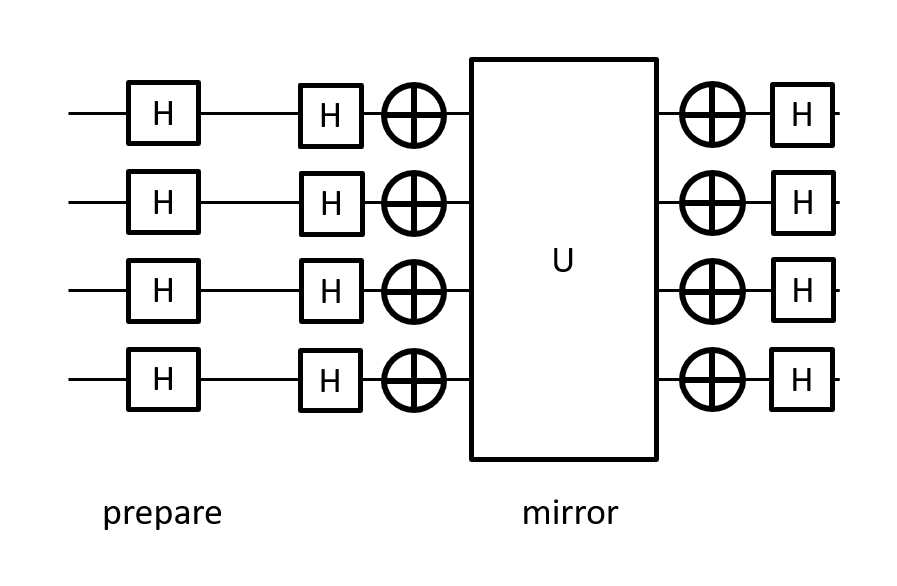

Q# provides built-in functionality for this using `within / apply`:

In [12]:
open Microsoft.Quantum.Diagnostics;
    
operation Mirror(oracle: (Qubit[] => Unit is Adj), qubits: Qubit[]) : Unit
is Adj {

    Message("Before:");
    DumpMachine();
    
    within {
        ApplyToEachA(H, qubits);
        ApplyToEachA(X, qubits);
    }
    apply {
        oracle(qubits);
    }

    Message("After:");
    DumpMachine();
}

Mirror

Notice also the [`DumpMachine`](https://docs.microsoft.com/en-us/quantum/techniques/testing-and-debugging?#dump-functions) calls. As in a real QPU, Q# does not allow you to access the qubit's state. However, you can use [`DumpMachine`](https://docs.microsoft.com/en-us/quantum/techniques/testing-and-debugging?#dump-functions) to have the simulator output to the console its internal status and debug your code:

In [13]:
open Microsoft.Quantum.Arrays;

operation Phase (qubits : Qubit[]) : Unit
is Adj {
    Controlled Z (Rest(qubits), Head(qubits));
}

operation TestMirror() : Unit {
    using (qubits = Qubit[4]) {
        let oracle = Phase;
        let uniformSuperposition = ApplyToEachA(H, _);

        uniformSuperposition(qubits);
        Mirror(oracle, qubits);
        
        ResetAll(qubits);
    }
}

Phase, TestMirror

In [14]:
%simulate TestMirror

Before:
# wave function for qubits with ids (least to most significant): 0;1;2;3
∣ 0❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 1❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 2❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 3❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 4❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 5❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 6❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 7❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 8❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     --- [  0.00000 rad ]
∣ 9❭:	 0.250000 +  0.000000 i	 == 	**                   [ 0.062500 ]     

()

Callables are first class objects in Q#. Functions and operations can:
- be used as parameters of other callables: `oracle` in `Mirror` is an input parameter.
- be assigned to variables, like `Phase` is assigned to `oracle` inside the `TestMirror` function
- created from other callables by using *partial-application*: partial application happens when you invoke a callable, but leave some of the parameters missing using `_`; Q# automatically creates another operation that receives the missing parameters as arguments. For example `uniformSuperposition` is a partial application of `ApplyToEachA(H, _)`, since the argument missing for `ApplyToEach` is the input array, the `uniformSuperposition` is now a function that takes an array as a single argument.

The `%estimate` command lets you estimate the resources a given quantum operation will need to execute, without actually executing the operation. Similar to `%simulate` it takes the name of a no-arguments operation. However, `%estimate` does not keep track of the qubit's state and will not return the output of the operation, instead it returns the estimated values of how many resources, like Qubits and CNOT gates, the corresponding operation will use:

In [15]:
%estimate TestMirror

[CNOT, 30], [QubitClifford, 28], [R, 0], [Measure, 4], [T, 21], [Depth, 14], [Width, 5], [BorrowedWidth, 0]

To learn more about resources estimation, take a look at [The ResourcesEstimator Target Machine](https://docs.microsoft.com/en-us/quantum/machines/resources-estimator?) documentation.

## The Workspace

The notebook uses the folder it lives on disk to define a workspace. It will try to compile all the Q# files (i.e. all files with a `.qs` extension) it finds under the current folder and will make the operations it finds available to operations in the notebook. For example, the [Operations.qs](/edit/Operations.qs) file in this folder defines two operations:
* Microsoft.Quantum.Samples.IsMinus
* Microsoft.Quantum.Samples.IsPlus

To get the list of operations defined in the workspace, you can use the `%workspace` command:

In [16]:
%workspace

Microsoft.Quantum.Samples.IsMinus, Microsoft.Quantum.Samples.IsPlus

These operations can be used in this notebook, for example:

In [17]:
open Microsoft.Quantum.Samples;

operation CheckPlus() : Bool {
    mutable result = false;
    
    using (q = Qubit()) {
        PreparePlus(q);
        set result = IsPlus(q);
        
        Reset(q);
    }

    return result;
}

CheckPlus

In [18]:
%simulate CheckPlus

True

To pick up any changes you make to a Q# file in the workspace, use `%workspace reload`. 

In [19]:
%workspace reload

Microsoft.Quantum.Samples.IsMinus, Microsoft.Quantum.Samples.IsPlus

## Getting Help ##

Q# supports adding documentation to operations via comments in the code. When such documentation exists, you can access it from the notebook by adding a question mark before or after the operation name on a code cell, for example:

In [20]:
Microsoft.Quantum.Intrinsic.X?

Microsoft.Quantum.Intrinsic.X

This documentation is available for any operations in the Prelude, Canon and Workspace, or even those defined locally in the notebook:

In [21]:
PreparePlus?

PreparePlus

### `%who`

`%who` returns the list of all local and workspace operations available.

In [22]:
%who

AlwaysZero, CheckPlus, Hello, HelloQuantum, LoopAlwaysZero, Main, Microsoft.Quantum.Samples.IsMinus, Microsoft.Quantum.Samples.IsPlus, Mirror, Phase, PrepareMinus, PreparePlus, QNRG, QNRG2, TestMirror

### `%package`

`%package` allows you to load nuget packages and makes available any Q# operations defined on them. For example, to use the operations from [Q#'s Quantum Chemistry Library](https://docs.microsoft.com/en-us/quantum/libraries/chemistry/?view=qsharp-preview), you must load the [Microsoft.Quantum.Chemistry](https://www.nuget.org/packages/Microsoft.Quantum.Chemistry/) nuget package:

In [23]:
%package Microsoft.Quantum.Chemistry

Microsoft.Quantum.Standard::0.9.1909.3002, Microsoft.Quantum.Chemistry::0.9.1909.3002

`%package` returns the list of nuget packages currently loaded and their version.

### `%version`

`%version` simply returns the current versions of IQ# and of Jupyter Core (a library used by IQ#):

In [24]:
%version

Component,Version
iqsharp,0.9.1909.3002
Jupyter Core,1.1.18837.0
